## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from random import sample
import re

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
#if not os.path.exists('sonnets.txt'):
    #!wget https://github.com/EvgenVer/ml_course/tree/main/homeworks/lab02_deep_learning/sonnets.txt
#text=[]

#with open('sonnets.txt', 'r') as iofile:
    #text.append(iofile.readlines())

#TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616"

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
text = [re.sub(r'([[].+[]])', '', x) for x in text]
text = [re.sub(r'[\s][\s]+', '', x) for x in text]

--2023-09-22 15:20:40--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.005s  

2023-09-22 15:20:40 (49.6 MB/s) - ‘onegin.txt’ saved [262521/262521]



<ipython-input-4-3b953e2e93b9>:7: FutureWarning: Possible nested set at position 2
  text = [re.sub(r'([[].+[]])', '', x) for x in text]


In [5]:
MAX_LENGTH = max(map(len, text))
MAX_LENGTH

49

In [6]:
len(text)

7088

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(list(set(text)))
num_tokens = len(tokens)
print(f'num_tokens = {num_tokens}')
print(tokens)

num_tokens = 78
['\n', ' ', '!', '(', ')', ',', '-', '.', '5', ':', ';', '?', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

print(token_to_idx)
print(idx_to_token)

{'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, ':': 9, ';': 10, '?': 11, '^': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, '«': 38, '»': 39, 'а': 40, 'б': 41, 'в': 42, 'г': 43, 'д': 44, 'е': 45, 'ж': 46, 'з': 47, 'и': 48, 'й': 49, 'к': 50, 'л': 51, 'м': 52, 'н': 53, 'о': 54, 'п': 55, 'р': 56, 'с': 57, 'т': 58, 'у': 59, 'ф': 60, 'х': 61, 'ц': 62, 'ч': 63, 'ш': 64, 'щ': 65, 'ъ': 66, 'ы': 67, 'ь': 68, 'э': 69, 'ю': 70, 'я': 71, 'ё': 72, '–': 73, '—': 74, '’': 75, '…': 76, '€': 77}
{0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: ',', 6: '-', 7: '.', 8: '5', 9: ':', 10: ';', 11: '?', 12: '^', 13: 'a', 14: 'b', 15: 'c', 16: 'd', 17: 'e', 18: 'f', 19: 'g', 20: 'h', 21: 'i', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w',

In [10]:
def encod(sec):
    encod_sec = [token_to_idx[s] for s in sec]
    return encod_sec

In [11]:
batch = encod(text[:128])
embed = nn.Embedding(78, 20)
res = embed(torch.LongTensor(batch))
res.size(0)

128

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [13]:
# Your code here
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = torch.tanh(self.rnn_update(x_and_h))

        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)




In [14]:
def rnn_loop(char_rnn, batch_ix):
    batch_size = batch_ix.size(0)
    hid_state = char_rnn.initial_state(batch_size).to(device)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

In [15]:
#char_rnn = CharRNNCell()
#batch_ix = encod(text[:128])
#batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
#batch_ix = batch_ix.view(1,128)
#logit_seq = rnn_loop(char_rnn, batch_ix)
#print(batch_ix[:, 1:].size())
#print(logit_seq.size())
#print(logit_seq[:, :-1].size())
#print(batch_ix[:,1:].size())

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [16]:
# Your plot code here
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

loss_history = []
n_epochs = 100
batch_size = 256


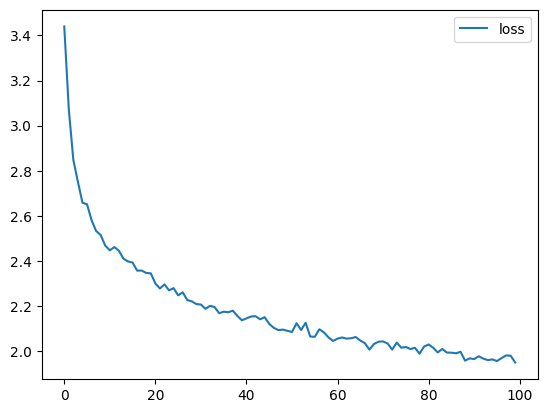

In [17]:
for ep in range(n_epochs):
    ep_loss = []
    for i in range(len(text) % batch_size):
        start_batch = np.random.randint(0, len(text)-batch_size-1)
        batch = encod(text[start_batch:start_batch+batch_size])
        batch = torch.tensor(batch, dtype=torch.int64)
        batch = batch.view(1, batch_size)
        batch = batch.to(device)

        logits_seq = rnn_loop(char_rnn, batch)

        pred_logits = logits_seq[:, :-1]
        actual_next_tokens = batch[:, 1:]

        loss = loss_func(
            pred_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )

        loss.backward()
        opt.step()
        opt.zero_grad()

        ep_loss.append(loss.item())

    loss_history.append(np.mean(ep_loss))

    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()


assert np.mean(loss_history[:10]) > np.mean(loss_history[-10:]), "RNN didn't converge."




In [18]:
def generate_sample(char_rnn, seed_phrase='Герой', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0]

        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [19]:
print(generate_sample(char_rnn=char_rnn, seed_phrase='герой', max_length=700, temperature=0.5))

герой делу стариньем
не друг летовно уж стельным;
вдруг поднем веререй нас оскавить?
но вертину свои полно,
к стужет межденной красный,
и мой не страней молодной
славля не разность от сада
и верник мезденой в нашей дерей
и верно сварок и в нас не моей,
кровины весная кладней,
но как глята с сердце славой
на цол: на умин и сужда.
старый не вках и собой.



xxvi

богутной когородною странье,
когда в оставать на света
на славно старить не воле
слезанной по видей брещений
сого не круг он.



xxii

когорок в собой покреми, вот речей.
еще в том облаждет ее старит,
верно стариком и в ваш подна
татьяна пред вечельной не сталатный
и применский молодой,
на должне ветренно слезой,
и то в ей не блестной


In [34]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=18, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.train = True
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(input_size=emb_size,
                          hidden_size=rnn_num_units,
                          batch_first=True,
                          num_layers=2)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hid_state=None):
        if self.train:
            h_seq, _ = self.rnn(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits
        else:
            h_seq, hid_state = self.rnn(self.emb(x), hid_state)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hid_state

model = CharRNNLoop().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
loss_history = []
n_epochs = 100
batch_size = 256



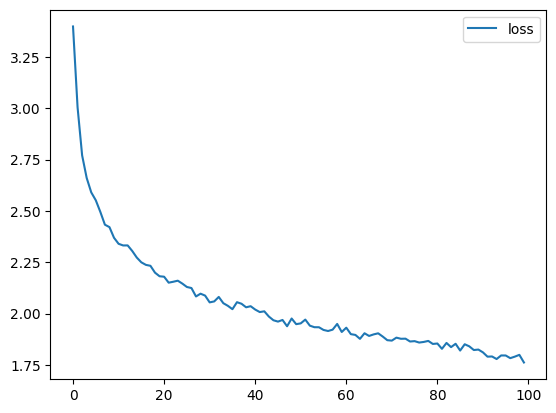

In [35]:
model.train = True
for ep in range(n_epochs):
    ep_loss = []
    for i in range(len(text) % batch_size):
        start_batch = np.random.randint(0, len(text)-batch_size-1)
        #start_batch = i * batch_size
        batch = encod(text[start_batch:start_batch+batch_size])
        batch = torch.tensor(batch, dtype=torch.int64)
        batch = batch.view(1, batch_size)
        batch = batch.to(device)

        logits_seq = model(batch)

        pred_logits = logits_seq[:, :-1]
        actual_next_tokens = batch[:, 1:]


        loss = loss_func(
            pred_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )

        loss.backward()
        opt.step()
        opt.zero_grad()

        ep_loss.append(loss.item())

    loss_history.append(np.mean(ep_loss))

    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(loss_history[:10]) > np.mean(loss_history[-10:]), "RNN didn't converge."

In [36]:
def generate_sample(model, max_length, seed_phrase='Герой', temperature=1.0):

    model.train = False

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    hid_state = None
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [37]:
print(generate_sample(model, max_length=700, seed_phrase='мой дядя самых честных правил', temperature=0.5))

мой дядя самых честных правила?»
еще но в ней он он молча,
в глуши с ним скрыла мой.



xxvii

и восподной заметит а страд.



xxi

но покойной и в глушать,
и с нам поворотило отот
с ним сталом ворвенные меня,
в перемет не хоть в солной.



xii

как убором молчался на сторон.
с колетой взор и постеренье,
что полные страда люблю.



xxxi

в койных своей сердца сторон,
он свои страстных сводилась,
в ней стольно запред неволе
и татьяна по мне струдает
и сердца постеленье,
ужель поками расселенье,
но только в романилась сон,
и был не вновь почелованье
в сем на взор в послушный звучный,
я после я расках разумный стучит,
когда приятнице в семья
к беревно летильный спорой
и в осьзоркала свой модной


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [62]:
# LSTM
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=18, num_units=128):
        super(self.__class__, self).__init__()
        self.train = True
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size,
                          hidden_size=num_units,
                          batch_first=True,
                          num_layers=2)
        self.hid_to_logits = nn.Linear(num_units, num_tokens)

    def forward(self, x, hid_state=None):
        if self.train:
            h_seq, _ = self.lstm(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits
        else:
            h_seq, hid_state = self.lstm(self.emb(x), hid_state)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hid_state

model = CharLSTMLoop().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
loss_history = []
n_epochs = 200
batch_size = 256

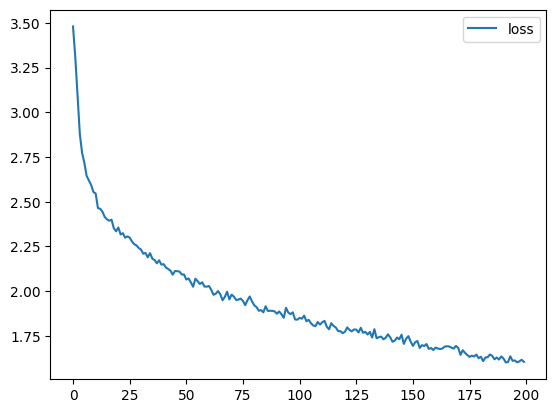

In [63]:
model.train = True
for ep in range(n_epochs):
    ep_loss = []
    for i in range(len(text) % batch_size):
        start_batch = np.random.randint(0, len(text)-batch_size-1)
        #start_batch = i * batch_size
        batch = encod(text[start_batch:start_batch+batch_size])
        batch = torch.tensor(batch, dtype=torch.int64)
        batch = batch.view(1, batch_size)
        batch = batch.to(device)

        logits_seq = model(batch)

        pred_logits = logits_seq[:, :-1]
        actual_next_tokens = batch[:, 1:]


        loss = loss_func(
            pred_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )

        loss.backward()
        opt.step()
        opt.zero_grad()

        ep_loss.append(loss.item())

    loss_history.append(np.mean(ep_loss))

    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(loss_history[:10]) > np.mean(loss_history[-10:]), "RNN didn't converge."

In [66]:
def generate_sample(model, max_length, seed_phrase='Герой', temperature=1.0):

    model.train = False

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    hid_state = None
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = model(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [69]:
# Text generation with different temperature values here
temperature = [0.1, 0.2, 0.5, 1.0, 2.0]
for i in temperature:
    print('='*30 + f'Temperature: {i} + "="*30')
    print(generate_sample(model, max_length=300, seed_phrase='мой дядя самых честных правил\n', temperature=i))


==============================Temperature: 0.1 + "="*30
мой дядя самых честных правил
и света страдали полный,
и в сердце с ним обо всех пора,
и в сердце с ним обедали света,
и в страшно в семью сердце моей
и в сердце с ней отверен полный,
и слава страстей пораженье,
и в страстей в сердце головой,
и в сердце с ним обеду моей
и в сердце в сердце своей све
==============================Temperature: 0.2 + "="*30
мой дядя самых честных правил
и в сердце в сердце своей страха,
и вот онегин постеленный,
и волнала с ним под ними,
и в сердце горова страсти
с постеле прости моей.



xliii

как буду там и в том странный,
и вас одна бы в сердце в сень,
и всё да страсти моей света
страстей веселый полной света,
и в 
==============================Temperature: 0.5 + "="*30
мой дядя самых честных правил
и скоро тревожат полна,
в гостиный взгляд об ней дома;
но я вольнося страсти моды
и сумом в сень онегиная,
и богу, тайный души моей
и в моря в делаю страсти,
и вас на сказала порой.
но все просто и со

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)